In [1]:
# Setup (Imports)

from LoadData import *

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

import numpy as np

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Setup (Globals/Hyperz)

window_size = 30
epochs      = 600
batch_size  = 64

In [3]:
# Loading and Splitting Data

def get_data(stock, ratio=.80, variation='lstm'):
    
    data = csv_as_numpy(stock)[1][:, 3] # 3 = Closing Price
    
    train_size = int(len(data) * ratio)
    
    if variation == 'lstm':
    
        trainX, trainY = create_chunks(data[: train_size], window_size, norm=True)

        testX, testY = create_chunks(data[train_size:], window_size, norm=True)

        trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
        testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
        
    elif variation == 'mlp':
    
        trainX, trainY = create_chunks(data[: train_size], window_size, norm=True)

        testX, testY = create_chunks(data[train_size:], window_size, norm=True)
    
    return (trainX, trainY), (testX, testY)


In [4]:
# Setup (Create Model)

def get_model(variation='lstm'):
    
    if variation == 'lstm':

        model = Sequential()

        model.add(LSTM(16, input_shape=(1, window_size), return_sequences=True))

        model.add(LSTM(16, return_sequences=False))

        model.add(Dense(10, activation='relu'))

        model.add(Dense(1))

        model.compile(loss='mse', optimizer='adam')
        
    elif variation == 'mlp':
        
        model = Sequential()

        model.add(Dense(5, input_dim=window_size, activation='relu'))
        model.add(Dropout(.25))
        
        model.add(Dense(5, activation='relu'))
        model.add(Dropout(.25))
        
        model.add(Dense(5, activation='relu'))
        model.add(Dropout(.25))
        
        model.add(Dense(1))

        model.compile(loss='mse', optimizer='adam')
    
    return model


In [5]:
# Run (Load)

(trainX, trainY), (testX, testY) = get_data('AAPL', variation='lstm')

print(trainX.shape, trainY.shape)


(3533, 1, 30) (3533,)


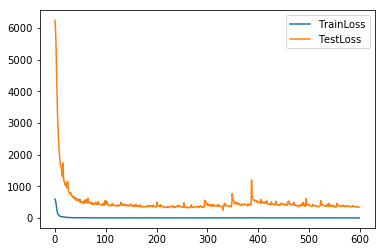

In [6]:
# Run (Train)

model = get_model(variation='lstm')

history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, validation_data=(testX, testY), verbose=0)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['TrainLoss', 'TestLoss'])
plt.show()


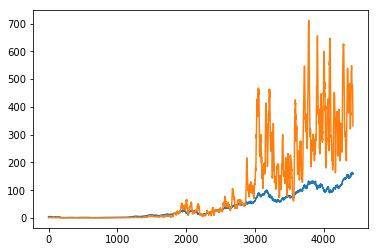

In [7]:
# Test

data = csv_as_numpy('AAPL')[1][:, 3]

data = data[:]

prices_actual = []
prices_predicted = []

for i in range(len(data) - window_size - 1):
        
    X = data[i: i + window_size]
    Y = data[i + window_size]
    
    prices_actual.append(Y)
    
    X = np.array([X])
    
    mean, std = np.mean(X), np.std(X) 
    
    X = X - mean / std
    
    prediction = model.predict(np.reshape(X, (X.shape[0], 1, X.shape[1])))
    
    prediction = prediction * std + mean
    
    prices_predicted.append(np.squeeze(prediction))

plt.plot(prices_actual)
plt.plot(prices_predicted)
plt.show()
